### ARIMA mit exogener Variable anlernen (Kapitel 4.8)
#### Daten laden und Datumsindex einstellen

In [1]:
import pandas as pd
from math import ceil

pd.set_option('display.max_columns', 6)
data_url=r'https://github.com/tplusone/hanser_ml_zeitreihen/blob/master/Daten/sales_dat_prep.csv?raw=true'
df = pd.read_csv(data_url, parse_dates=True, index_col=0)
df.index.freq='W'
df.head()

,Weekly_Sales,holiday
Date,,
2010-01-10,23381.380,0.0
2010-01-17,23381.380,0.0
2010-01-24,23381.380,0.0
2010-01-31,23381.380,0.0
2010-02-07,24427.815,0.0


#### 2) Verlauf der zu prognostizierenden Variable prüfen

<AxesSubplot:xlabel='Date'>

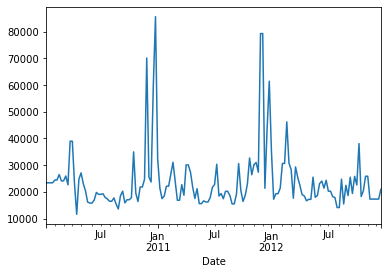

In [2]:
df['Weekly_Sales'].plot()

### TEIL 1: Preprocessing

#### 1) Daten stationär machen

<AxesSubplot:xlabel='Date'>

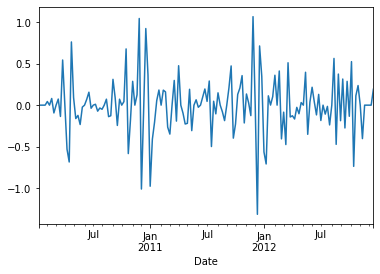

In [3]:
import numpy as np

# Logarithmieren
df['log_sales'] = np.log(df['Weekly_Sales'])
# First Differences
df['diff_log'] = df['log_sales'].diff()
df['diff_log'].plot()

#### 2) Auf Stationarität prüfen

In [4]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['diff_log'].dropna())
print("Test statistic = {:.4f}".format(result[0]))
print("P-value = {:.4f}".format(result[1]))

Test statistic = -6.2165
P-value = 0.0000


#### 3) Autokorrelationsdiagramm / partielle Autokorrelationsdiagramme prüfen

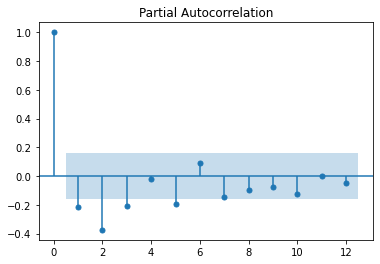

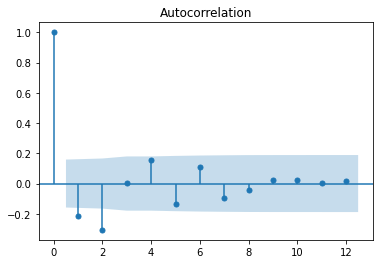

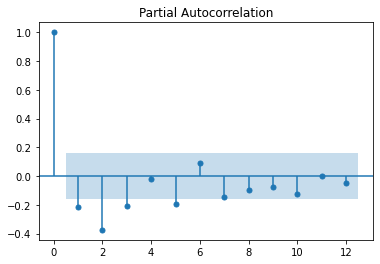

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['diff_log'].dropna(), lags=12)
plot_pacf(df['diff_log'].dropna(), lags=12)

#### 4) Train-Test-Split durchführen

In [6]:
end_train = int(len(df)*0.8)
df_train = df.iloc[:end_train]
df_test = df.iloc[end_train:]
df_train.shape, df_test.shape

((123, 4), (31, 4))

### TEIL II: ARIMA-Modell anlernen

#### 1) Exogene und endogene Variablen aus Train/Test-Daten selektieren

In [7]:
X_train = df_train['log_sales']
X_train_exog = df_train['holiday']
X_test = df_test['log_sales']
X_test_exog = df_test['holiday']
X_train[:5], X_train_exog[:5]

(Date
 2010-01-10    10.059695
 2010-01-17    10.059695
 2010-01-24    10.059695
 2010-01-31    10.059695
 2010-02-07    10.103478
 Freq: W-SUN, Name: log_sales, dtype: float64,
 Date
 2010-01-10    0.0
 2010-01-17    0.0
 2010-01-24    0.0
 2010-01-31    0.0
 2010-02-07    0.0
 Freq: W-SUN, Name: holiday, dtype: float64)

#### 2) ARIMA-Modell aufsetzen und anlernen

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

result = SARIMAX(X_train, exog=X_train_exog,
        order=((1,0,1),0,0)).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                 log_sales   No. Observations:                  123
Model:             SARIMAX([1, 3], 0, 0)   Log Likelihood                 -33.925
Date:                   Tue, 08 Sep 2020   AIC                             75.850
Time:                           15:54:53   BIC                             87.099
Sample:                       01-10-2010   HQIC                            80.420
                            - 05-13-2012                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday        0.2419      0.056      4.348      0.000       0.133       0.351
ar.L1          0.6708      0.045     14.961      0.000       0.583       0.759
ar.L3          0.3289      0.045      7.317      0.000       0.241       0.417
sigma2         0.0958      0.010      9.858      0.000       0.077       0.115
===================================================================================
Ljung-Box (Q):                       36.30   Jarque-Bera (JB):                 7.73
Prob(Q):                              0.64   Prob(JB):                         0.02
Heteroskedasticity (H):               1.78   Skew:                             0.10
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 3) Evaluation über Testdaten
Dazu das Modell mit den Testdaten versorgen, so dass Schätzungen mit aktualisierten Werten möglich sind

In [9]:
model = SARIMAX(X_test, exog=X_test_exog, 
            order=((1,0,1),0,0))
result_new = model.filter(result.params)
y_pred_test = result_new.predict(start='2012-05-27')
y_pred_test = np.exp(y_pred_test)
y_pred_test[:5]

Date
2012-05-27    17855.973480
2012-06-03    18380.129220
2012-06-10    21205.534025
2012-06-17    22038.181252
2012-06-24    21867.826819
Freq: W-SUN, dtype: float64

Ergebnisse graphisch darstellen (Zeitraum Testdaten: true vs. predicted)

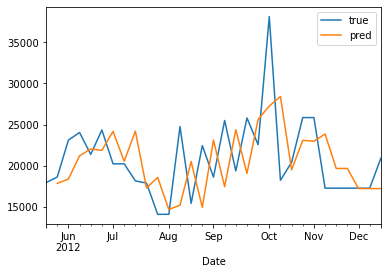

In [10]:
import matplotlib.pyplot as plt
np.exp(X_test).plot(label='true')
y_pred_test.plot(label='pred')
plt.legend()

#### 4)  Modell ohne exogene Variable anlernen und Schätzwerte berechnen

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
arima2 = SARIMAX(X_train, order=((1,0,1),0,0))
result2 = arima2.fit()
model2 = SARIMAX(X_test, order=((1,0,1),0,0))
result_new2 = model2.filter(result2.params)
y_pred_test2 = result_new2.predict(start='2012-05-27')
y_pred_test2 = np.exp(y_pred_test2)
y_pred_test2[:5]

Date
2012-05-27    17852.593753
2012-06-03    18380.973971
2012-06-10    21259.346264
2012-06-17    22094.760548
2012-06-24    21845.893866
Freq: W-SUN, dtype: float64

#### 5) Mean absolute error vergleichen (Modell mit/ohne exogene Variable)

In [12]:
from sklearn.metrics import mean_absolute_error

y_true_test = np.exp(X_test[1:])
mae_arima_exo = mean_absolute_error(y_true_test, y_pred_test)
mae_arima_noexo = mean_absolute_error(y_true_test, y_pred_test2)
print('Mean absolute Error (mae)')
print('ARIMA mit exo: {:.3f}'.format(mae_arima_exo))
print('ARIMA ohne exo: {:.3f}'.format(mae_arima_noexo))

Mean absolute Error (mae)
ARIMA mit exo: 3984.923
ARIMA ohne exo: 4224.083


Unterschiede der Modelle (Schätzung über Testdaten) graphisch darstellen

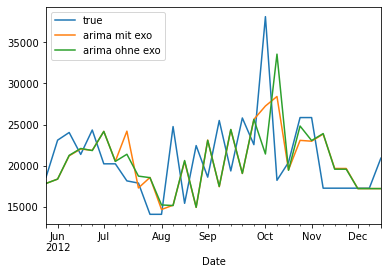

In [13]:
import matplotlib.pyplot as plt
y_true_test.plot(label='true')
y_pred_test.plot(label='arima mit exo')
y_pred_test2.plot(label='arima ohne exo')
plt.legend()